## make sure you have all libraries installed. 
use conda environment: /scratch/da2734/twitter/worldbank_twitter_environment.yml

# loading random and filtered samples

In [1]:
# filtered contains 0.8G of data!!
import time
start_time = time.time()
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
month = '2012-1'
path_to_data = '/scratch/spf248/twitter/data/classification/US/filtered_10perct_sample//'
tweets_filtered=pq.ParquetDataset(glob(os.path.join(path_to_data,                                           
#                                            country_code,
#                                            month,
                                           '*.parquet'))).read().to_pandas()
tweets_filtered['tweet_id'] = tweets_filtered['tweet_id'].astype(int)
print('time taken to load keyword filtered sample:', str(time.time() - start_time), 'seconds')
print(tweets_filtered.shape)

time taken to load keyword filtered sample: 44.65053915977478 seconds
(9215824, 11)


In [2]:
# random contains 0.8G of data!!
import time
start_time = time.time()
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
month = '2012-1'
path_to_data = '/scratch/spf248/twitter/data/classification/US/random_10perct_sample/'
tweets_random=pq.ParquetDataset(glob(os.path.join(path_to_data,                                           
#                                            country_code,
#                                            month,
                                           '*.parquet'))).read().to_pandas()
tweets_random['tweet_id'] = tweets_random['tweet_id'].astype(int)
print('time taken to load random sample:', str(time.time() - start_time), 'seconds')
print(tweets_random.shape)

time taken to load random sample: 36.8915913105011 seconds
(9468992, 11)


In [4]:
# all in one loop
import glob
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt

boundary = 0.725

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start_time = time.time()
    model_output_path = '/scratch/da2734/twitter/running_on_200Msamples/pred_output/{}/'.format(column)
    model_output_filtered = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'filtered*.csv')], ignore_index = True)
    print('time taken to load filtered sample:', str(time.time() - start_time), 'seconds', model_output_filtered.shape)


    start_time = time.time()
    model_output_random = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'random*.csv')], ignore_index = True)
    print('time taken to load random sample:', str(time.time() - start_time), 'seconds', model_output_random.shape)


    start_time = time.time()
    merged_filtered = pd.merge(model_output_filtered, tweets_filtered, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    merged_random = pd.merge(model_output_random, tweets_random, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    pickle.dump( merged_filtered, open( "./top_tweets/{}_merged_filtered.pkl".format(column), "wb" ) )
    pickle.dump( merged_random, open( "./top_tweets/{}_merged_random.pkl".format(column), "wb" ) )
    print('time taken to dump:', str(time.time() - start_time), 'seconds')

    merged_filtered = merged_filtered[['neg_model', 'pos_model', 'text']]
    merged_random   = merged_random[['neg_model', 'pos_model', 'text']]
    
#     print(column)
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.hist(merged_filtered['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.title(column+' filtered')
# #     ax.set_yscale('log')
#     plt.xlim(0,1.1)
    
#     fig = plt.figure()
#     ax = plt.subplot(111)
#     plt.hist(merged_random['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.title(column+' random')
# #     ax.set_yscale('log')
#     plt.xlim(0,1.1)
    
#     print(column)
#     start_time = time.time()
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_pos_100.csv'.format(column))
#     print(sort_merged_filtered.head())
    
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_neg_100.csv'.format(column))
#     print(sort_merged_filtered.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')

#     print(column)
#     start_time = time.time()
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_pos_100.csv'.format(column))
#     print(sort_merged_random.head())
    
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_neg_100.csv'.format(column))
#     print(sort_merged_random.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')


    merged_filtered['dist_point{}'.format(boundary)] = abs(merged_filtered['pos_model'] - boundary)

    start_time = time.time()
    print(column, 'filtered subtraction time taken:', str(time.time() - start_time), 'seconds')

    start_time = time.time()
    merged_filtered = merged_filtered.sort_values(by=['dist_point{}'.format(boundary)], ascending=True)
    print(column, 'filtered sorting time taken:', str(time.time() - start_time), 'seconds')

    start_time = time.time()
    merged_filtered[:100].to_csv('top_tweets/filtered_{}_point_{}.csv'.format(column, boundary))
    # print(all_filtered_boundary['text'])
    print(column, 'filtered write csv time taken:', str(time.time() - start_time), 'seconds')


    merged_random['dist_point{}'.format(boundary)] = abs(merged_random['pos_model'] - boundary)

    start_time = time.time()
    print(column, 'random subtraction time taken:', str(time.time() - start_time), 'seconds')

    start_time = time.time()
    merged_random = merged_random.sort_values(by=['dist_point{}'.format(boundary)], ascending=True)
    print(column, 'random sorting time taken:', str(time.time() - start_time), 'seconds')

    start_time = time.time()
    merged_random[:100].to_csv('top_tweets/random_{}_point_{}.csv'.format(column, boundary))
    # print(all_random_boundary['text'])
    print(column, 'random write csv time taken:', str(time.time() - start_time), 'seconds')    
    
    
#     break

is_unemployed
time taken to load filtered sample: 0.22882080078125 seconds (440264, 3)
time taken to load random sample: 0.24871277809143066 seconds (504964, 3)
time taken to merge: 5.92163348197937 seconds (440264, 13)
time taken to merge: 5.823861598968506 seconds (440264, 13)
time taken to dump: 0.6184859275817871 seconds
is_unemployed filtered subtraction time taken: 1.6689300537109375e-06 seconds
is_unemployed filtered sorting time taken: 0.12904882431030273 seconds
is_unemployed filtered write csv time taken: 0.02643561363220215 seconds
is_unemployed random subtraction time taken: 1.430511474609375e-06 seconds
is_unemployed random sorting time taken: 0.18461084365844727 seconds
is_unemployed random write csv time taken: 0.0038814544677734375 seconds
lost_job_1mo
time taken to load filtered sample: 1.0465576648712158 seconds (528010, 3)
time taken to load random sample: 1.3284051418304443 seconds (589139, 3)
time taken to merge: 5.784589052200317 seconds (528010, 13)
time taken to

is_unemployed
time taken to load filtered sample: 0.1852726936340332 seconds (440264, 3)
time taken to load random sample: 0.18742775917053223 seconds (504964, 3)
time taken to merge: 4.930733680725098 seconds (440264, 13)
time taken to merge: 5.073297500610352 seconds (440264, 13)
time taken to dump: 0.43390941619873047 seconds
is_unemployed
lost_job_1mo
time taken to load filtered sample: 0.1674671173095703 seconds (528010, 3)
time taken to load random sample: 0.17806339263916016 seconds (589139, 3)
time taken to merge: 4.840052604675293 seconds (528010, 13)
time taken to merge: 5.218229055404663 seconds (528010, 13)
time taken to dump: 0.521223783493042 seconds
lost_job_1mo
job_search
time taken to load filtered sample: 2.8843283653259277 seconds (9215824, 3)
time taken to load random sample: 2.9363160133361816 seconds (9468992, 3)
time taken to merge: 7.280039310455322 seconds (9215824, 13)
time taken to merge: 7.229210376739502 seconds (9215824, 13)
time taken to dump: 10.45475292

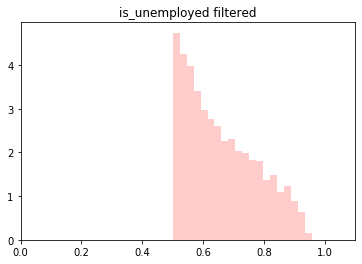

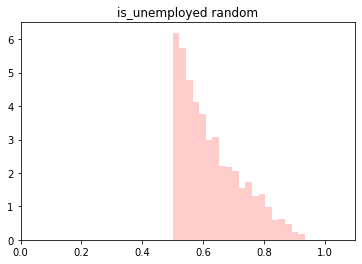

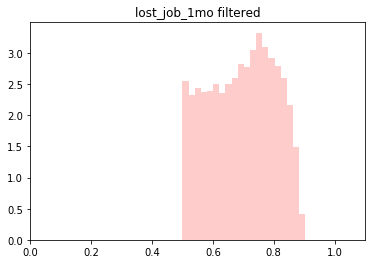

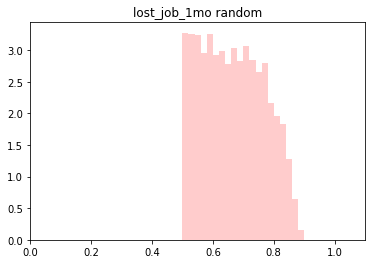

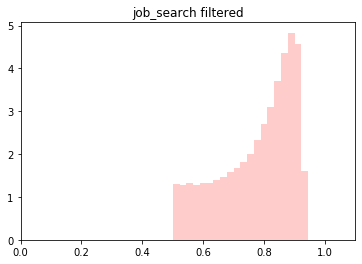

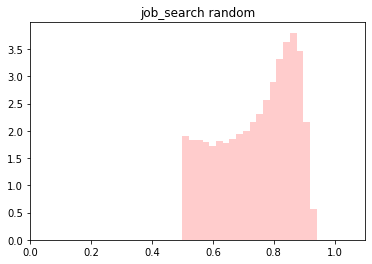

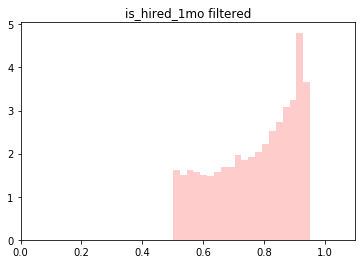

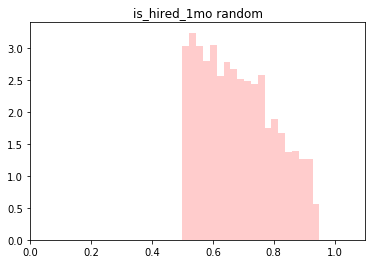

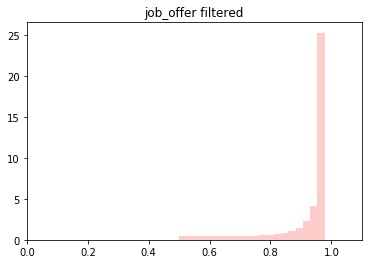

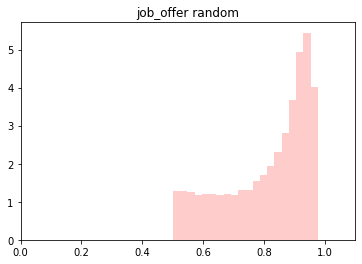

In [4]:
# all in one loop
import glob
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt

boundary = 0.5

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start_time = time.time()
    model_output_path = '/scratch/da2734/twitter/running_on_200Msamples/pred_output/{}/'.format(column)
    model_output_filtered = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'filtered*.csv')], ignore_index = True)
    print('time taken to load filtered sample:', str(time.time() - start_time), 'seconds', model_output_filtered.shape)


    start_time = time.time()
    model_output_random = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'random*.csv')], ignore_index = True)
    print('time taken to load random sample:', str(time.time() - start_time), 'seconds', model_output_random.shape)


    start_time = time.time()
    merged_filtered = pd.merge(model_output_filtered, tweets_filtered, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    merged_random = pd.merge(model_output_random, tweets_random, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    pickle.dump( merged_filtered, open( "./top_tweets/{}_merged_filtered.pkl".format(column), "wb" ) )
    pickle.dump( merged_random, open( "./top_tweets/{}_merged_random.pkl".format(column), "wb" ) )
    print('time taken to dump:', str(time.time() - start_time), 'seconds')

    merged_filtered = merged_filtered[['neg_model', 'pos_model', 'text']]
    merged_random   = merged_random[['neg_model', 'pos_model', 'text']]
    
    merged_random = merged_random[merged_random['pos_model'] > 0.5 ]
    
    merged_filtered = merged_filtered[merged_filtered['pos_model'] > 0.5 ]

    
    print(column)
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged_filtered['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.title(column+' filtered')
#     ax.set_yscale('log')
    plt.xlim(0,1.1)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged_random['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.title(column+' random')
#     ax.set_yscale('log')
    plt.xlim(0,1.1)
    
#     print(column)
#     start_time = time.time()
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_pos_100.csv'.format(column))
#     print(sort_merged_filtered.head())
    
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_neg_100.csv'.format(column))
#     print(sort_merged_filtered.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')

#     print(column)
#     start_time = time.time()
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_pos_100.csv'.format(column))
#     print(sort_merged_random.head())
    
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_neg_100.csv'.format(column))
#     print(sort_merged_random.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')


#     merged_filtered['dist_point5'] = abs(merged_filtered['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'filtered subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered = merged_filtered.sort_values(by=['dist_point5'], ascending=True)
#     print(column, 'filtered sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered[:100].to_csv('top_tweets/filtered_{}_point5.csv'.format(column))
#     # print(all_filtered_boundary['text'])
#     print(column, 'filtered write csv time taken:', str(time.time() - start_time), 'seconds')


#     merged_random['dist_point5'] = abs(merged_random['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'random subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random = merged_random.sort_values(by=['dist_point5'], ascending=True)
#     print(column, 'random sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random[:100].to_csv('top_tweets/random_{}_point5.csv'.format(column))
#     # print(all_random_boundary['text'])
#     print(column, 'random write csv time taken:', str(time.time() - start_time), 'seconds')    
    
    
#     break

In [ ]:
# entropy
import glob
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np

boundary = 0.5

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start_time = time.time()
    model_output_path = '/scratch/da2734/twitter/running_on_200Msamples/pred_output/{}/'.format(column)
    model_output_filtered = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'filtered*.csv')], ignore_index = True)
    print('time taken to load filtered sample:', str(time.time() - start_time), 'seconds', model_output_filtered.shape)


    start_time = time.time()
    model_output_random = pd.concat([pd.read_csv(f) for f in glob.glob(model_output_path+'random*.csv')], ignore_index = True)
    print('time taken to load random sample:', str(time.time() - start_time), 'seconds', model_output_random.shape)


    start_time = time.time()
    merged_filtered = pd.merge(model_output_filtered, tweets_filtered, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    merged_random = pd.merge(model_output_random, tweets_random, how='inner', on = 'tweet_id')
    print('time taken to merge:', str(time.time() - start_time), 'seconds', merged_filtered.shape)

    start_time = time.time()
    pickle.dump( merged_filtered, open( "./top_tweets/{}_merged_filtered.pkl".format(column), "wb" ) )
    pickle.dump( merged_random, open( "./top_tweets/{}_merged_random.pkl".format(column), "wb" ) )
    print('time taken to dump:', str(time.time() - start_time), 'seconds')

    merged_filtered = merged_filtered[['neg_model', 'pos_model', 'text']]
    merged_random   = merged_random[['neg_model', 'pos_model', 'text']]
    
#     merged_random = merged_random[merged_random['pos_model'] > 0.5 ]

    merged_filtered['entropy'] = - merged_filtered['pos_model']*(np.log(merged_filtered['pos_model']))
    merged_random['entropy'] = - merged_random['pos_model']*(np.log(merged_random['pos_model']))
    
#     merged_filtered = merged_filtered[merged_filtered['pos_model'] > 0.5 ]

    
    print(column)
    fig = plt.figure()
    ax = plt.subplot(111)
#     plt.hist(merged_filtered['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.hist(merged_filtered['entropy'], bins=20, density = True, color = 'red', alpha = 0.2)    
    plt.title(column+' filtered')
#     ax.set_yscale('log')
#     plt.xlim(0,1.1)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged_random['entropy'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.hist(merged_random['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
    plt.title(column+' random')
#     ax.set_yscale('log')
#     plt.xlim(0,1.1)
    
#     print(column)
#     start_time = time.time()
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_pos_100.csv'.format(column))
#     print(sort_merged_filtered.head())
    
#     sort_merged_filtered = merged_filtered.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_filtered.head(100).to_csv('top_tweets/filtered_{}_neg_100.csv'.format(column))
#     print(sort_merged_filtered.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')

#     print(column)
#     start_time = time.time()
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=False)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_pos_100.csv'.format(column))
#     print(sort_merged_random.head())
    
#     sort_merged_random = merged_random.sort_values(by=['pos_model'], ascending=True)
#     sort_merged_random.head(100).to_csv('top_tweets/random_{}_neg_100.csv'.format(column))
#     print(sort_merged_random.head())
#     print('time taken to save csv:', str(time.time() - start_time), 'seconds')


#     merged_filtered['dist_point5'] = abs(merged_filtered['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'filtered subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered = merged_filtered.sort_values(by=['dist_point5'], ascending=True)
#     print(column, 'filtered sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_filtered[:100].to_csv('top_tweets/filtered_{}_point5.csv'.format(column))
#     # print(all_filtered_boundary['text'])
#     print(column, 'filtered write csv time taken:', str(time.time() - start_time), 'seconds')


#     merged_random['dist_point5'] = abs(merged_random['pos_model'] - boundary)

#     start_time = time.time()
#     print(column, 'random subtraction time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random = merged_random.sort_values(by=['dist_point5'], ascending=True)
#     print(column, 'random sorting time taken:', str(time.time() - start_time), 'seconds')

#     start_time = time.time()
#     merged_random[:100].to_csv('top_tweets/random_{}_point5.csv'.format(column))
#     # print(all_random_boundary['text'])
#     print(column, 'random write csv time taken:', str(time.time() - start_time), 'seconds')    
    
    
#     break